## Fraud Transaction Detection
In this Jupyter Notebook, we delve into the realm of fraud transaction detection, a critical aspect of ensuring the security and integrity of financial systems.And it serves as a comprehensive guide to understanding and implementing fraud detection in a real-world context, combining data exploration, machine learning, and practical strategies for fraud prevention.

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/Fraud/Fraud.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


We don't need of customer who started the transaction and customer who is the recipient of the transaction as the would not make any sense in fraud detection. So we can drop *nameOrig* and *nameDest*.

In [6]:
df.drop(labels=['nameOrig','nameDest'],axis=1,inplace=True)

We can make rename *newbalanceOrig* to *newbalanceOrg* for making same pattern.

In [7]:
df.rename(columns={'newbalanceOrig':'newbalanceOrg'}, inplace= True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrg   float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
 8   isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 436.9+ MB


In [9]:
df.shape

(6362620, 9)

In the data there is 6362620 rows, as well as 9 features. Here our target variable is **isFraud** and this is the actual fruad status of the transaction made by someone.We use some threshold value to the transction to make a indicator **isFlaggedFraud**.

In [10]:
df.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrg     0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

As we can easily see that there is no null value.

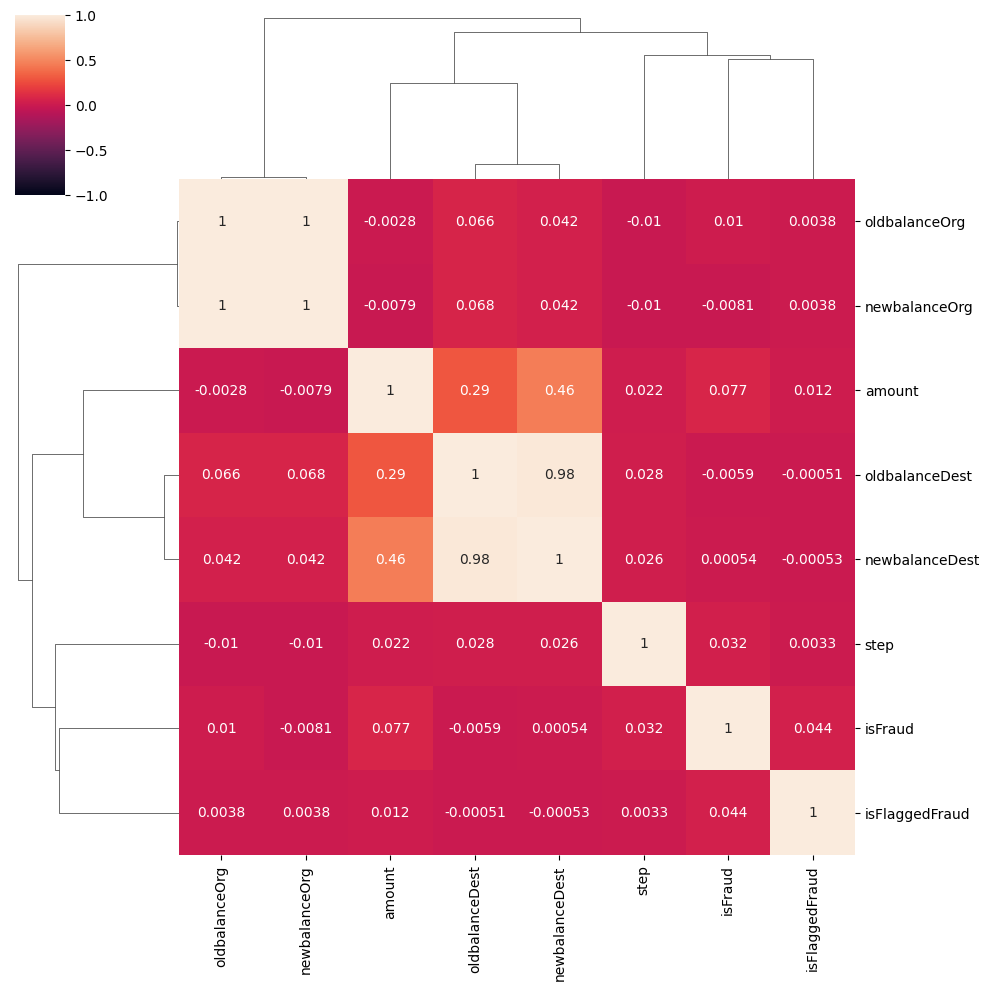

In [11]:
sns.clustermap(df.corr(),vmin=-1,vmax=1,annot=True)

As from the cluster map it is clear that:
- oldbalanceOrg and newbalanceOrg is highly corelated.
- oldbalanceDest and newbalanceDest is also highly corelated.


There is not much co-relation between other features. Then what we can do is find out the heatmap relation of fraud and non-fraud type of transaction.

In [12]:
df_fraud=df.loc[df.isFraud==1]
df_nonfraud=df.loc[df.isFraud==0]

In [13]:
print("Number of Fraud happening :{}\n Number of flagged as Fraud: {}".format(df_fraud.shape[0],df_fraud.loc[df_fraud.isFlaggedFraud==1].shape[0]))

Number of Fraud happening :8213
 Number of flagged as Fraud: 16


In [14]:
print("Number of transaction which is not-Fraud :{}\n But Number of flagged as Fraud: {}".format(df_nonfraud.shape[0],df_nonfraud.loc[df_nonfraud.isFlaggedFraud==1].shape[0]))

Number of transaction which is not-Fraud :6354407
 But Number of flagged as Fraud: 0


If we focus on the **isFraud and isFlaggedFraud** there is a connection between them.When system raises a red flag (isFlaggedFraud), it's often means there's something wrong with the transaction(isFraud). So **isFlaggedFraud** is not making any sense in ml model we can drop it.

In [15]:
df=df.drop('isFlaggedFraud',axis=1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrg   float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


<Axes: xlabel='type', ylabel='amount'>

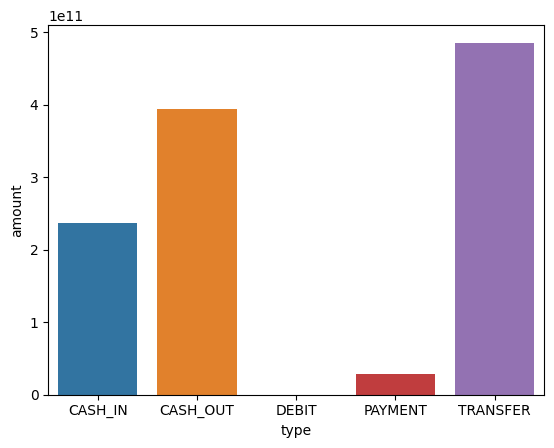

In [17]:
df1=df.groupby('type').amount.sum().reset_index()
sns.barplot(data=df1, x="type", y="amount")

In [18]:
df.loc[df.isFraud==1].type.unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

From the above two things we can see that **CASH_OUT and TRANSFER** is most used transaction mode and also fraud is happening from both of them.Then we need to focus on this type of transaction.

Certainly, for the task of proactive fraud detection, a Random Forest classification model can be a suitable choice. It offers a robust and versatile approach to handling classification problems.A Random Forest is like a group of decision trees working together to make predictions. Each tree in the forest independently evaluates data and collectively provides a more accurate outcome. It's known for its capability to handle complex relationships in data and is well-suited for classification tasks like identifying fraudulent transactions.

In [19]:
df.type.value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df.type = le.fit_transform(df.type)
df.type.value_counts()

1    2237500
3    2151495
0    1399284
4     532909
2      41432
Name: type, dtype: int64

In [21]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)

In [24]:
RF = RandomForestClassifier()

RF.fit(X_train, y_train)
y_p = RF.predict(X_test)
print(average_precision_score(y_p, y_test))

0.7675753203155052


In [27]:
!pip install scikit-plot

[[1906307      44]
 [    523    1912]]


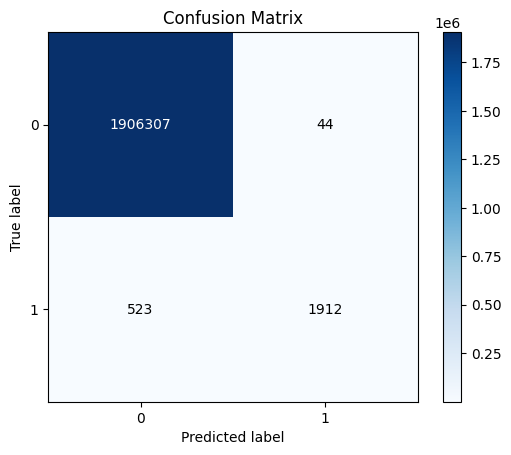

In [28]:
import scikitplot as skplt
from sklearn.metrics import confusion_matrix

# Example confusion matrix (replace this with your actual values)
cm = confusion_matrix(y_test, y_p)
print(cm)
# Create a confusion matrix plot
skplt.metrics.plot_confusion_matrix(y_test, y_p, normalize=False)
plt.show()

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_p))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.98      0.79      0.87      2435

    accuracy                           1.00   1908786
   macro avg       0.99      0.89      0.94   1908786
weighted avg       1.00      1.00      1.00   1908786



In our fraud detection project, we used a Random Forest model to identify fraudulent transactions. The classification report provides us with valuable insights into how well our model is performing.

**Precision** measures how many of the transactions our model predicted as fraudulent were actually fraudulent. For non-fraudulent transactions (class 0), our model achieved a perfect precision score of 1.00, which means that when it predicted a transaction as non-fraudulent, it was correct every time. For fraudulent transactions (class 1), our model achieved a very high precision score of 0.98, indicating that 98% of the transactions it predicted as fraudulent were indeed fraudulent. This is crucial because it minimizes false alarms, reducing unnecessary actions.

**Recall**, also known as sensitivity or true positive rate, measures how well our model identifies all actual fraudulent transactions. For non-fraudulent transactions (class 0), our model achieved a perfect recall score of 1.00, meaning it correctly identified all non-fraudulent transactions. However, for fraudulent transactions (class 1), our recall score is 0.79, indicating that our model successfully detected 79% of the actual fraudulent cases. While not perfect, this is still quite good and ensures we don't miss many fraudulent transactions.

The **F1-Score** is a balanced metric that considers both precision and recall. For non-fraudulent transactions (class 0), it's a perfect 1.00, indicating a harmonious balance between precision and recall. For fraudulent transactions (class 1), the F1-score is 0.87, suggesting that our model strikes a good balance between correctly identifying fraudulent cases and minimizing false alarms.

The **Support** values tell us the number of samples in each class in our test dataset. In this case, we have a large number of non-fraudulent transactions (1,906,351) and a smaller number of fraudulent transactions (2,435).

The **Accuracy** score reflects the overall correctness of our model's predictions. With an accuracy of 1.00 (or 100%), our model performed exceptionally well in distinguishing between fraudulent and non-fraudulent transactions.

The **Macro Average** provides an average summary across both classes. The macro average precision, recall, and F1-score are all close to 1.00, suggesting that our model performs well overall.

The **Weighted Average** accounts for class imbalance, as we have many more non-fraudulent transactions than fraudulent ones. In this case, all the weighted average metrics are 1.00, indicating that our model handles the class imbalance effectively.

In summary, our Random Forest model demonstrates strong performance in fraud detection. It achieves high precision, recall, and F1-score for both classes, indicating that it effectively identifies fraudulent transactions while keeping false alarms to a minimum. With an accuracy of 1.00, our model excels in distinguishing between genuine and fraudulent transactions, providing a robust solution for fraud detection.

<BarContainer object of 7 artists>

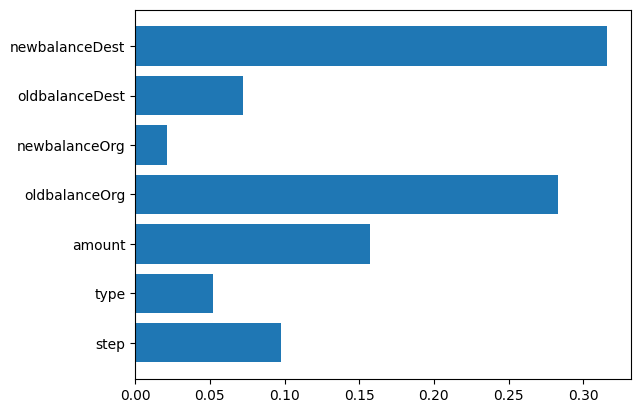

In [30]:
plt.barh(X.columns, RF.feature_importances_)

Here we can easily see which fearture is important for the model. **newbalanceDest and oldbalanceOrg** having much importance.

### What kind of prevention should be adopted while company update its infrastructure?


*   As in the model we can see it is effective at minimizing false alarms(high precession for class1) it's important to focus on the false negative. To prevent these, we may introduce addition layer tothe security or fraud detection mechanism to catch any fraud missed.
*   Anf addition to that we can update infrastructure to ensure that model is regularly update with new data, as we can find the fraud patterns.



### Assuming these actions have been implemented, how would you determine if they work?



*   Then we should continously monitor the model performence such as precision , recall and confusion matrix.
*   We can establish one feedback loop which are going to fine tune the model and improves its performence
*   We also can benchmark it. Analyze whether the prevention measures have reduced the company's losses due to fraud and if the cost of implementing these measures is justified.
*    Gather feedback from relevant stakeholders, including fraud analysts and investigators, to assess the effectiveness of the prevention strategies from their perspective.

